In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("nodes.csv")
df = df.drop("Unnamed: 0", axis=1)
df_pivoted = df.pivot_table(index=['timestamp', 'node'], columns='feature', values='value')
df_pivoted.columns = ['Feature0', 'Feature1', 'Feature2', 'Feature3']
df_final = df_pivoted.reset_index()
df_final = df_final.drop(['timestamp', 'node'],axis=1)

In [3]:
X = df_final[['Feature3']]
y = df_final[['Feature0', 'Feature1', 'Feature2']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators = 300,random_state=42))
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Training MSE: {train_mse}')
print(f'Testing MSE: {test_mse}')

Training MSE: 0.01211529297608951
Testing MSE: 0.09121461348538122


In [5]:
print(y_test_pred)
print([y_test])

[[0.66289643 0.56597966 0.50016763]
 [0.45540718 0.48903806 0.41439651]
 [0.44207399 0.32746643 0.7761009 ]
 ...
 [0.6761643  0.38392215 0.49894506]
 [0.47999628 0.23788819 0.15202685]
 [0.53726518 0.26239938 0.24736653]]
[      Feature0  Feature1  Feature2
1447  0.445096  0.269808  0.713312
1114  0.306864  0.841292  0.637170
1064  0.386003  0.602291  0.818530
2287  0.743285  0.379226  0.446170
1537  0.483352  0.484818  0.444191
...        ...       ...       ...
427   0.444806  0.337360  0.455317
105  -0.027288  0.603666  0.673054
2044  0.805178  0.753384  0.603866
121   0.285652  0.007341  0.038768
821   0.449801  0.146336  0.273443

[750 rows x 3 columns]]


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt


In [7]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_final[['Feature3']])

X_train, X_test, y_train, y_test = train_test_split(X_poly, df_final[['Feature0', 'Feature1', 'Feature2']], test_size=0.3, random_state=42)


In [8]:
param_grid_rf = {
    'estimator__n_estimators': [100, 200,30],
    'estimator__max_depth': [None, 10, 20,30],
    'estimator__min_samples_split': [2, 5,7]
}

param_grid_gb = {
    'estimator__n_estimators': [100, 200,300,400],
    'estimator__learning_rate': [0.01, 0.1, 0.2,0.001],
    'estimator__max_depth': [3, 5, 10]
}

param_grid_svr = {
    'estimator__C': [0.1, 1, 10,0.001],
    'estimator__epsilon': [0.01, 0.1, 0.2]
}

In [9]:
models = [
    ('RandomForest', RandomForestRegressor(random_state=42), param_grid_rf),
    ('GradientBoosting', GradientBoostingRegressor(random_state=42), param_grid_gb),
    ('SVR', SVR(), param_grid_svr)
]

best_model = None
best_score = float('inf')
for name, model, param_grid in models:
    multi_output_model = MultiOutputRegressor(model)
    grid_search = GridSearchCV(multi_output_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    if grid_search.best_score_ < best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_

In [10]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Best Model: {best_model}')
print(f'Training MSE: {train_mse}')
print(f'Testing MSE: {test_mse}')

Best Model: MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=10,
                                                     min_samples_split=7,
                                                     n_estimators=200,
                                                     random_state=42))
Training MSE: 0.04558638580698134
Testing MSE: 0.06457279701703482


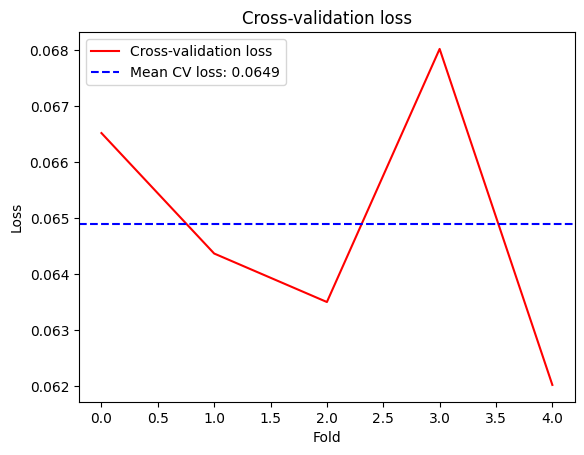

In [11]:
cv_results = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mean = -cv_results.mean()

plt.plot(range(len(cv_results)), -cv_results, 'r', label='Cross-validation loss')
plt.axhline(cv_mean, color='b', linestyle='--', label=f'Mean CV loss: {cv_mean:.4f}')
plt.title('Cross-validation loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
import joblib
joblib.dump(best_model, 'best_model.pkl')


['best_model.pkl']

In [25]:
def predict_feature3(feature3_value):
    # Load the pretrained model
    model = joblib.load('best_model.pkl')
    
    # Transform the input feature
    feature3_poly = poly.transform([[feature3_value]])
    
    # Predict using the model
    prediction = model.predict(feature3_poly)
    
    return prediction

# Example usage
feature3_input = 	0.6957890011388101
predicted_values = predict_feature3(feature3_input)
print(f'Predicted values for Feature3={feature3_input}: {predicted_values}')

Predicted values for Feature3=0.6957890011388101: [[0.49680177 0.38926703 0.44937163]]


C:\Users\sandy\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
